We need too Import Google Drive lib to work with files online


In [64]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


Importing Kaggle-cli lib to work with dataset from www.kaggle.com

In [65]:
!pip install kaggle
!pip install kaggle-cli

Dowloading RSNA Pneumonia dataset from the  kaggle competition page: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

In [66]:
!ls

drive					       stage_2_test_images.zip
GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_2_train_images.zip
sample_data				       stage_2_train_labels.csv
stage_2_detailed_class_info.csv		       stage_train_images
stage_2_sample_submission.csv


In [67]:
!kg download  -u konstantinmeskhidze -p lutkostya123456789 -c rsna-pneumonia-detection-challenge

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_2_detailed_class_info.csv

stage_2_detailed_class_info.csv already downloaded !
downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_2_sample_submission.csv

stage_2_sample_submission.csv already downloaded !
downloading https://www.kaggle.com/c/rsna-p

To work with medical images we need to install pydicom lib cause all patients' pictures are in [dicom](https://en.wikipedia.org/wiki/DICOM ) format

In [68]:
! pip install pydicom

In [69]:
! pip install tqdm
! pip install imgaug

In [0]:
#import libraries
import os 
import sys
import random
import math
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import pandas as pd 

Lets see what folders and files we have in the colab's content

In [71]:
print(os.listdir("/content"))

['sample_data', '.config', 'GCP%20Credits%20Request%20Link%20-%20RSNA.txt', 'drive', 'stage_2_test_images.zip', 'stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', 'stage_train_images', 'stage_2_train_images.zip']


In [0]:
# let's unzip train images zip file  into a folder 
import zipfile
with zipfile.ZipFile("stage_2_train_images.zip","r") as zip_ref:
    zip_ref.extractall("stage_train_images")

In [0]:
Path_train_dicom_image = "stage_train_images"

Path_train_boxes_image = "drive/My Drive/Colab/Kaggle_RSA_Competition/stage_2_train_labels.csv"

Path_additional_info = "drive/My Drive/Colab/Kaggle_RSA_Competition/stage_2_detailed_class_info.csv"



In [74]:
#Let's count how many train images are in the dataset
!ls '/content/stage_train_images/' -1A | wc -l

26684


**dataset_load()** - returns a list of dicom images in a folder and images' additional information.

**dataset_list_load()** - returns a list of dicom images in a folder.



In [0]:
def dataset_load (image_dir, image_info_file):
    lstFilesDCM = []
    for dirName, subdirList, fileList in os.walk(image_dir):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

    image_info = {pat: [] for pat in lstFilesDCM}
    for index, row in image_info_file.iterrows():
        pat = os.path.join(image_dir, row['patientId']+'.dcm')
        image_info[pat].append(row)
    return lstFilesDCM, image_info
  
def dataset_list_load (image_dir):
    lstFilesDCM = []
    for dirName, subdirList, fileList in os.walk(image_dir):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
    return lstFilesDCM 

Let's analyze **stage_2_train_labels.csv**  and ** stage_2_detailed_class_info.csv**


In [118]:
boxes_labels = pd.read_csv(Path_train_boxes_image)
boxes_labels.info()
boxes_labels.head(10)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [119]:
additional_info = pd.read_csv(Path_additional_info)
additional_info.info() 
additional_info.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
patientId    30227 non-null object
class        30227 non-null object
dtypes: object(2)
memory usage: 472.4+ KB


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


We can see that the train dataset has 26684 images but in **stage_1_train_labels.csv** and **stage_1_detailed_class_info.csv** files there are 30227 patiens Ids with 9555 nun-null Target features. That means that there could be situations when 1 patient has more than 1 Lung Opacity region 

Lets analyze a couple image dicom files with Lung Opacity and without it.

In [120]:
train_image_list= dataset_list_load(Path_train_dicom_image)


#  Get ref file
patient_normal = pydicom.read_file(train_image_list[0])
  
patient_normal  

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.29900.1517874494.494184
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '960131aa-4ce4-4b26-aa12-5f73d8d81453'
(0010, 0020) Patient ID                          LO: '960131aa-4ce4-4b26-aa12-5f73d8d81453'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

Here in **patient_normal** file  we are interested in Patient's Sex and Patient's Age features. This info  might help somehow to improve the future model.

In [0]:
# Root directory of the dcmpandas
dcmpandas_ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab/Kaggle_RSA_Competition/")

# Import dcm pandas
sys.path.append(dcmpandas_ROOT_DIR)  # To find local version of the lib
#sys.path.insert(1, dcmpandas_ROOT_DIR)

In [0]:
sys.path.remove('/content/drive/My Drive/Colab/Kaggle_RSA_Competition')

In [81]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/Colab/Kaggle_RSA_Competition',
 '/content/drive/My Drive/Colab/Kaggle_RSA_Competition']

**dcmpanas.py** file has got some functions to build a new Dataframe with* Patient's Sex* , *Patient's Age*  and *Target*  features . I'm going to use this new dataset to analyze the data.

In [83]:
#import dcmpandas functions
import dcmpandas as dp

print(dp)

<module 'dcmpandas' from '/content/drive/My Drive/Colab/Kaggle_RSA_Competition/dcmpandas.py'>


In [0]:

import os
import sys
import glob
import pydicom
import pandas as pd
import fnmatch
from tqdm import tqdm

def scrape(directory = '.',
           target_path = 'all/stage_2_train_labels.csv',
           database_file='dicom.csv',
           glob_pattern = '*',
           verbose_local = 0,
           verbose=1):
    """Scrape a directory of data
    """
    # Create A db of the entire dataset
    db = []
    target_data = pd.read_csv(target_path)	
    for root, dirnames, filenames in os.walk(directory):
        if verbose:
            print('Visiting ' + root)
        if root != directory:#and not recursive:
            continue
        for fn in tqdm(fnmatch.filter(filenames, glob_pattern)):
            f = os.path.join(root, fn)
            if not is_dicom(f):
                continue
            if verbose_local:              
                    print('Processing', f)
            try:
                ds = pydicom.read_file(f)
                h = {}
                for k in ds.keys():
                    # Skip images
                    if (k.group,k.elem) == (0x7fe0,0x0010):
                        continue
                    # Choose Patient's Sex 
                    if (k.group,k.elem) == (0x0010, 0x0040):
                        v = ds[k]
                        key = v.name
                        value = v.value
                        h[key] = value
                    # Choose just Patient's Age                        
                    if (k.group,k.elem) == (0x0010, 0x1010):
                        v = ds[k]
                        key = v.name
                        value = v.value
                        h[key] = int(value)
                    # Choose Patient's ID and value of Target
                    if (k.group,k.elem) == (0x0010, 0x0020):
                        v = ds[k]
                        key = v.name
                        value = v.value
                        h[key] = value
                        d = target_data[target_data['patientId'] == value]['Target']  
                        
                        if len(d) > 1:
                           h['Target'] = int(d.iloc[0])
                        else:
                           h['Target'] = int(d)
                           
                
                # add the row to a database
                db += [h]
            except:
                #print('failed:', h['Filename'])
                #fail_path.append(h['Filename'])
                read_error.append(1)
        
    # Create a dataset of everything
    df = pd.DataFrame.from_dict(db)
    # save to .CSV file
    df.to_csv(database_file, index=False)
    
def is_dicom(filename):
    try:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            return True
        return False
    except:
        return False

In [30]:
scrape('./stage_train_images', 'drive/My Drive/Colab/Kaggle_RSA_Competition/stage_2_train_labels.csv', 'drive/My Drive/Colab/Kaggle_RSA_Competition/dicom_analyze.csv')

  0%|          | 18/26684 [00:00<02:34, 172.84it/s]

Visiting ./stage_train_images


100%|██████████| 26684/26684 [02:36<00:00, 170.88it/s]


**scrape()** function passes 3 arguments: dicom images' folder, stage_1_train_labels.csv location, and output.csv location 

In [124]:
dicom_analyze = pd.read_csv('drive/My Drive/Colab/Kaggle_RSA_Competition/dicom_analyze (1).csv')
dicom_analyze.info()
dicom_analyze.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 4 columns):
Patient ID       26684 non-null object
Patient's Age    26684 non-null int64
Patient's Sex    26684 non-null object
Target           26684 non-null int64
dtypes: int64(2), object(2)
memory usage: 834.0+ KB


,Patient ID,Patient's Age,Patient's Sex,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,0
1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,1
3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,1


Let's do some data analysis

In [125]:
dicom_analyze.describe()



,Patient's Age,Target
count,26684.000000,26684.000000
mean,47.030018,0.225304
std,16.810578,0.417790
min,1.000000,0.000000
25%,34.000000,0.000000
50%,49.000000,0.000000
75%,59.000000,0.000000
max,155.000000,1.000000


We can see that max patient's age value is 155 years. This value is definitely an outlier.
But I'm a bit confused about the min value - 1 year old. Theoretically its possible that a toddler has been scanned by X-ray. But I consider this value is an outlier too.

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


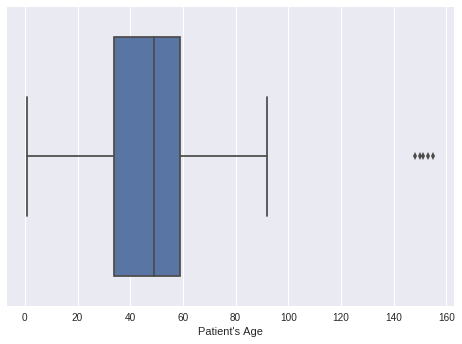

In [62]:
 sns.boxplot(x = "Patient's Age", data=dicom_analyze)

From the boxplot we can see that we have several outliers > 100 years old.
So 50% of all patients  fall  in a range between 34 and 59 years old.

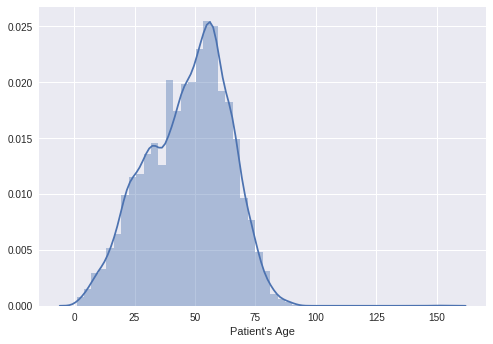

In [43]:
sns.distplot(dicom_analyze["Patient's Age"])

In [126]:
# Lets find out the persentage of male and female in the dataset
dicom_analyze["Patient's Sex"].value_counts(normalize=True)

M    0.568356
F    0.431644
Name: Patient's Sex, dtype: float64

We have 57% of men and 43% of women

In [127]:
# Lets find out the persentage of ill patients
dicom_analyze["Target"].value_counts(normalize=True)

0    0.774696
1    0.225304
Name: Target, dtype: float64

Just 22% of patients have pnemonia positive results

In [93]:
#Lets analyze the dataset of ill 
dicom_analyze_ill = dicom_analyze[dicom_analyze['Target'] == 1]
dicom_analyze_ill["Patient's Age"].describe()

count    6012.000000
mean       45.582502
std        17.468836
min         1.000000
25%        32.000000
50%        47.000000
75%        58.000000
max        92.000000
Name: Patient's Age, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


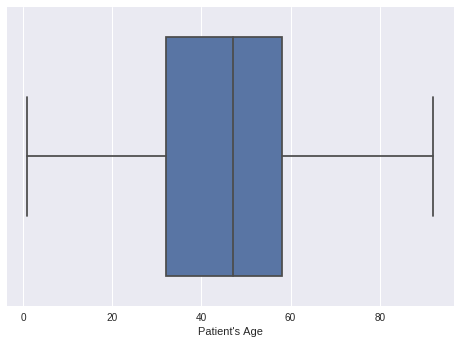

In [94]:
sns.boxplot(x = "Patient's Age", data=dicom_analyze_ill)

Here we have aproximately the same age discribution among  pnemionia positive patients:
Q1 - 32 years , Q3 - 58 years old

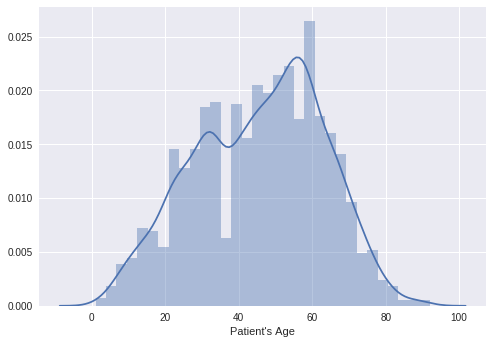

In [95]:
sns.distplot(dicom_analyze_ill["Patient's Age"])

Patien's Age distribution looks like Gaussian . It just has a failure in the plot at age 38

Now let's plot a couple if images - with pnemonia opacity and without one.
From box_labels.head() we can see that  patient **0004cfab-14fd-4e49-80ba-63a80b6bddd6** (index 0) has no lung opacity and the patient **00436515-870c-4b36-a041-de91049b9ab4** has 2 areas with lung opacity (4 and 5 indexes).

In [0]:
import matplotlib.patches as patches

patientId    00436515-870c-4b36-a041-de91049b9ab4
class                                Lung Opacity
Name: 4, dtype: object
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             562
y                                             152
width                                         256
height                                        453
Target                                          1
Name: 5, dtype: object


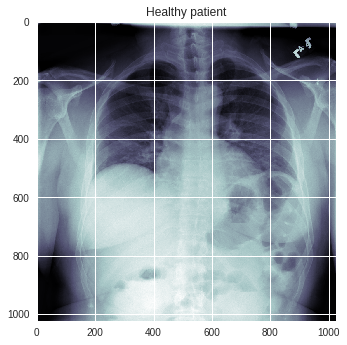

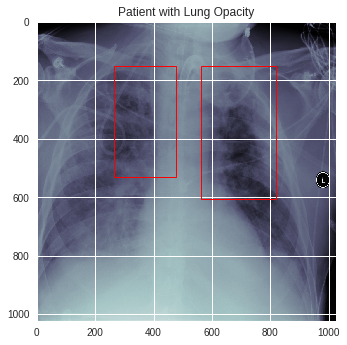

In [122]:


# Get ref file
 patient_normal = pydicom.read_file(train_image_list[0])


 # Get image array
 image_array_norm = patient_normal.pixel_array

 # Plot image
 plt.imshow(image_array_norm, cmap=plt.cm.bone) 
 plt.title('Healthy patient')


 # Get ref file
 patient_lung_op = pydicom.read_file(train_image_list[4])

 # Get image array
 image_array_lung_op = patient_lung_op.pixel_array

 # Create figure and axes
 fig,ax = plt.subplots(1)
 # Plot image
 ax.imshow(image_array_lung_op, cmap=plt.cm.bone) 
 plt.title('Patient with Lung Opacity')

 print(additional_info.iloc[4])
 print(boxes_labels.iloc[4])
 print(boxes_labels.iloc[5]) 
 


 # Create a Rectangle patch
 X_width_1= boxes_labels['width'].iloc[4]
 Y_width_1 = boxes_labels['height'].iloc[4]
  
 X_width_2 = boxes_labels['width'].iloc[5]
 Y_width_2 = boxes_labels['height'].iloc[5] 

 #  rectange X = upper left X of dicom
 X1 = boxes_labels['x'].iloc[4]
 #   rectange Y = upper left Y of dicom
 Y1 = boxes_labels['y'].iloc[4]
  
 #  rectange X = upper left X of dicom
 X2 = boxes_labels['x'].iloc[5]
 #   rectange Y = upper left Y of dicom
 Y2 = boxes_labels['y'].iloc[5] 

 box_1 = patches.Rectangle((X1,Y1),X_width_1,Y_width_1,linewidth=1,edgecolor='r',facecolor='none')
 box_2 = patches.Rectangle((X2,Y2),X_width_2,Y_width_2,linewidth=1,edgecolor='r',facecolor='none')

 # Add the box to the Plot
 ax.add_patch(box_1)
 ax.add_patch(box_2)
 plt.show()